In [1]:
import os
os.getcwd()
os.chdir("/home/aniket/Documents/datasets/fog parkinsons/dataset_fog_release/dataset")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

In [3]:
#creating a list of datasets where each element corresponds to a patient

allFiles = glob.glob(os.getcwd() + "/*.txt")
df = []
s = "Time of sample,Ankle_1,Ankle_2,Ankle_3,Thigh_1,Thigh_2,Thigh_3,Trunk_1,Trunk_2,Trunk_3,status"

for filename in allFiles:
        df.append(pd.read_csv(filename,sep = "\s+", header = None, names = s.split(",")))

In [4]:
# ignoring status = 0 as it's not part of the experiment
for i in range(len(df)):
    df[i] = df[i][df[i].status != 0]


In [5]:
# l = []
# for i in range(17):
#     l.append(df[i].shape)
# l
# s = 0
# for i in l:
#     s = s + i[0]
# s

1140835

In [6]:
#aggregate values of ankle_1, ankle_2 and ankle_3 into a single averaged value ankle, same for thigh, trunk

# def aggFeatures(df, feature1, feature2, feature3):
#     a = range(1,3)
#     s1 = [feature1 + "_" + str(i) for i in range(1,4)]
#     s2 = [feature2 + "_" + str(i) for i in range(1,4)]
#     s3 = [feature3 + "_" + str(i) for i in range(1,4)]
        
#     for i in range(len(df)):
#             df[i][feature1] = abs(df[i][s1[0]]) + abs(df[i][s1[1]]) + abs(df[i][s1[2]])
#             df[i][feature2] = abs(df[i][s2[0]]) + abs(df[i][s2[1]]) + abs(df[i][s2[2]])
#             df[i][feature3] = abs(df[i][s3[0]]) + abs(df[i][s3[1]]) + abs(df[i][s3[2]])
def aggFeatures(df, feature1, feature2, feature3):
    a = range(1,3)
    s1 = [feature1 + "_" + str(i) for i in range(1,4)]
    s2 = [feature2 + "_" + str(i) for i in range(1,4)]
    s3 = [feature3 + "_" + str(i) for i in range(1,4)]
        
    for i in range(len(df)):
            df[i][feature1] = (df[i][s1[0]]) + (df[i][s1[1]]) + (df[i][s1[2]])
            df[i][feature2] = (df[i][s2[0]]) + (df[i][s2[1]]) + (df[i][s2[2]])
            df[i][feature3] = (df[i][s3[0]]) + (df[i][s3[1]]) + (df[i][s3[2]])
                        

In [7]:
#check the dataset 

aggFeatures(df, "Ankle", "Thigh", "Trunk")
df[0].head()

,Time of sample,Ankle_1,Ankle_2,Ankle_3,Thigh_1,Thigh_2,Thigh_3,Trunk_1,Trunk_2,Trunk_3,status,Ankle,Thigh,Trunk
15999,250000,-161,1029,99,-190,981,171,58,1028,116,1,967,962,1202
16000,250015,-131,1019,89,-136,972,151,38,1000,106,1,977,987,1144
16001,250031,-121,1019,99,-100,981,111,9,990,155,1,997,992,1154
16002,250046,-111,1029,69,-81,981,90,29,1000,126,1,987,990,1155
16003,250062,-101,1019,59,-81,981,90,0,990,155,1,977,990,1145


In [7]:
i = 0
df[i][df[i].status == 1].head()

,Time of sample,Ankle_1,Ankle_2,Ankle_3,Thigh_1,Thigh_2,Thigh_3,Trunk_1,Trunk_2,Trunk_3,status,Ankle,Thigh,Trunk
15999,250000,-161,1029,99,-190,981,171,58,1028,116,1,967,962,1202
16000,250015,-131,1019,89,-136,972,151,38,1000,106,1,977,987,1144
16001,250031,-121,1019,99,-100,981,111,9,990,155,1,997,992,1154
16002,250046,-111,1029,69,-81,981,90,29,1000,126,1,987,990,1155
16003,250062,-101,1019,59,-81,981,90,0,990,155,1,977,990,1145


In [8]:
#selecting only status "1" and "2", "no FOG" and "FOG"
df_1 = []
df_2 = []

for i in range(17):
    df_1.append(df[i][df[i].status == 1])
    df_2.append(df[i][df[i].status == 2])


In [9]:
df_1[0].shape

(27254, 14)

## We will make recurrence plots for each attribute (ankle_1...etc) for each file

In [10]:
#checking the (rows, columns) of each instance of "1/Non-FOG" and "2/FOG"

for i in range(17):
    print(df_1[i].shape)

(27254, 14)
(99110, 14)
(52905, 14)
(27464, 14)
(19842, 14)
(22064, 14)
(94078, 14)
(56889, 14)
(142722, 14)
(36425, 14)
(50491, 14)
(70365, 14)
(74848, 14)
(21121, 14)
(14335, 14)
(132482, 14)
(87655, 14)


### (Issue) Recurrence plots for higher dimensional data is crashing for large data
We can eliminate this by taking a window of values, I have tested that we can send a length  of ~4000 array, hence I'll appropriately condense each feature

In [13]:
27256/8


3407.0

In [11]:
# defining a function to calculate average of values over a window 

def avgData(data, limit, window):
    data = np.array([sum(data.iloc[i:i+window])/window for i in range(0,limit, window)])
    return data

In [12]:
# defining a function to calculate recurrence plots for a particular data

from pyts.image import RecurrencePlots

# Recurrence plot transformation
rp = RecurrencePlots(dimension=1,
                     epsilon='percentage_points',
                     percentage=30)

def RP(data, limit = 0, window = 0, avg = False):
    if avg == True:
        data = avgData(data, limit, window)
        X_rp = rp.fit_transform(data.reshape(1,-1))
        plt.figure(figsize=(8, 8))
        plt.imshow(X_rp[0], cmap='binary', origin='lower')
        
    else:
        X_rp = rp.fit_transform(data.values.reshape(1,-1))
        # X_rp = rp.fit_transform(X)

        # Show the results for the first time series
        plt.figure(figsize=(8, 8))
        plt.imshow(X_rp[0], cmap='binary', origin='lower')
    return plt.show()

In [50]:
df_2[0].shape

(1547, 14)

#### Bottom 3 are RP's of Ankle_1, Ankle_2, Ankle_3 for Non-FOG 

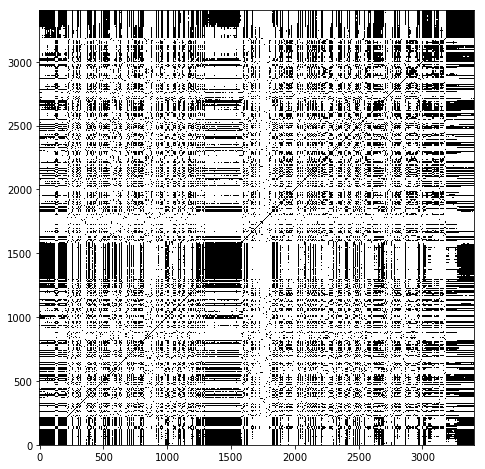

In [13]:
RP(df_1[0]["Ankle_1"], limit = 27256, window = 8, avg = True)

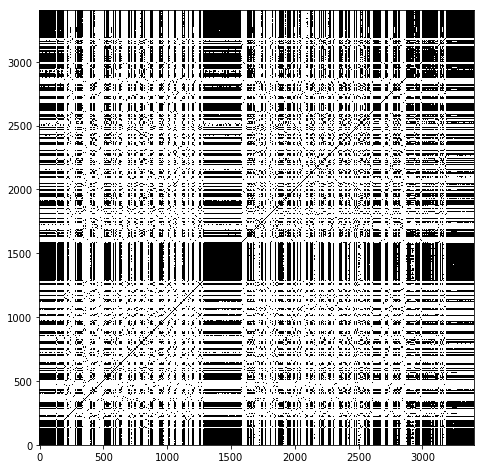

In [11]:
RP(df_1[0]["Ankle_2"], limit = 27256, window = 8, avg = True)

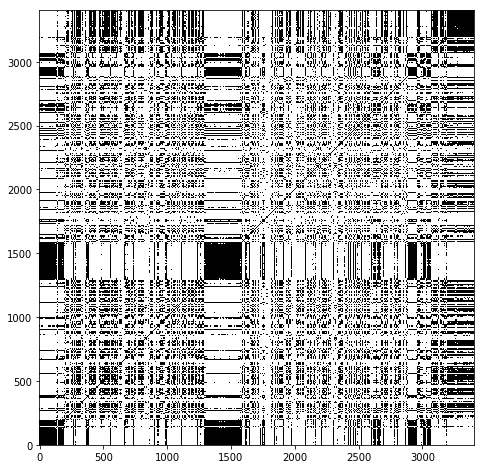

In [12]:
RP(df_1[0]["Ankle_3"], limit = 27256, window = 8, avg = True)

#### Bottom 3 are the RPs for Ankle_1, Ankle_2 and Ankle_3 for "FOG" events 

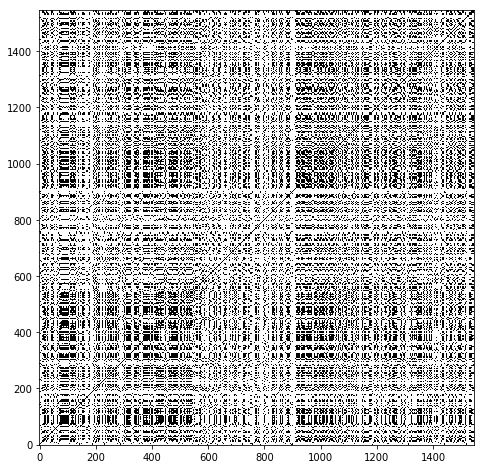

In [18]:
RP(df_2[0]["Ankle_1"], limit = 1547, window = 1, avg = False)

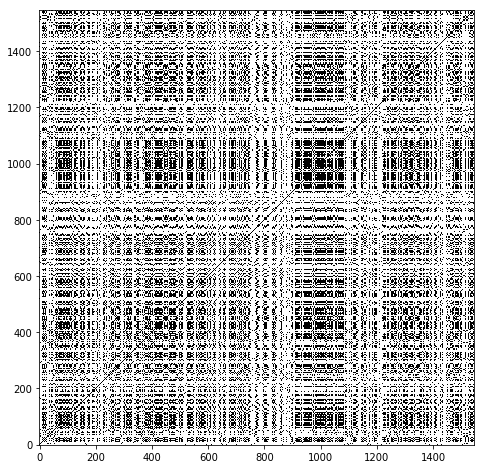

In [19]:
RP(df_2[0]["Ankle_2"], limit = 1547, window = 1, avg = False)

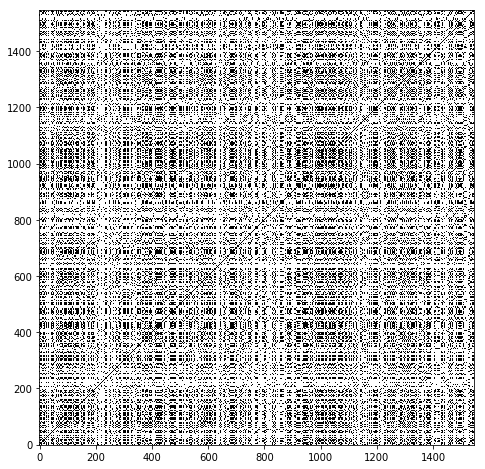

In [20]:
RP(df_2[0]["Ankle_3"], limit = 1547, window = 1, avg = False)

### Observations 
From the above observations we can see that recurrence patterns in "Non-FOG' events are more clearly defined than their "FOG" counterparts

In [198]:
# adding all "Non-FOG" into df_normal dataset

df_normal = df_1[0]

for i in range(1,17):
    df_normal = pd.concat([df_normal, df_1[i]])

df_normal.shape

(1030050, 14)

In [199]:
# adding all "FOG" into df_fog dataset

df_fog = df_2[0]

for i in range(1,17):
    df_fog = pd.concat([df_fog, df_2[i]])

df_fog.shape

(110785, 14)

In [200]:
# checking if the entire dataset was concatenated without hiccups 

df_normal.shape[0] + df_fog.shape[0]

1140835

##### WE can proceed to explore the data and see the relationships between the different features

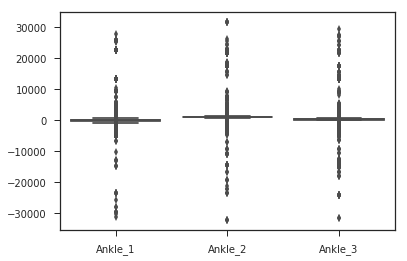

In [201]:
import seaborn as sns
sns.set(style="ticks", color_codes=True)

sns.boxplot(data=df_normal[["Ankle_1", "Ankle_2", "Ankle_3"]])
# sns.boxplot(x=df[0]["Ankle_1"])
# df_normal[["Ankle_1", "Ankle_2", "Ankle_3"]].describe()

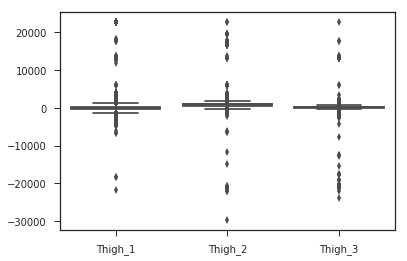

In [185]:
sns.boxplot(data=df_normal[["Thigh_1", "Thigh_2", "Thigh_3"]])

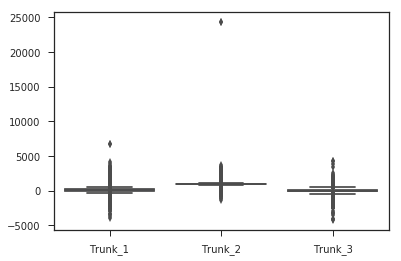

In [186]:
sns.boxplot(data=df_normal[["Trunk_1", "Trunk_2", "Trunk_3"]])

We see that for "Non-FOG" events the data for ankles, thigh and trunk is very wide

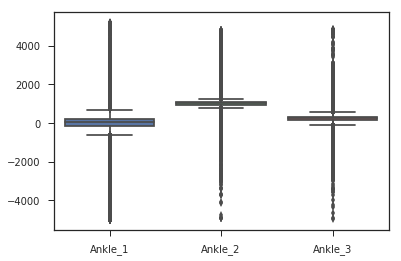

In [187]:
sns.boxplot(data=df_fog[["Ankle_1", "Ankle_2", "Ankle_3"]])

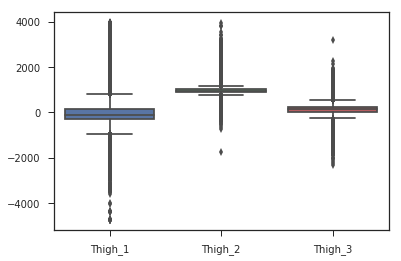

In [188]:
sns.boxplot(data=df_fog[["Thigh_1", "Thigh_2", "Thigh_3"]])

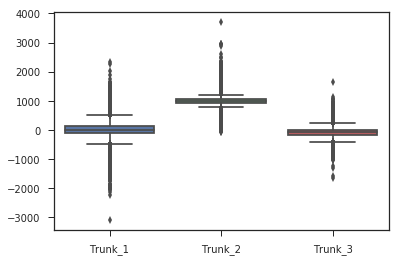

In [189]:
sns.boxplot(data=df_fog[["Trunk_1", "Trunk_2", "Trunk_3"]])

##### We can see the correlation between the different variables

In [204]:
df_normal.corr()

,Time of sample,Ankle_1,Ankle_2,Ankle_3,Thigh_1,Thigh_2,Thigh_3,Trunk_1,Trunk_2,Trunk_3,status,Ankle,Thigh,Trunk
Time of sample,1.000000,-0.099294,-0.062389,-0.031591,0.053845,-0.304672,-0.045569,-0.045076,-0.262843,-0.011670,NaN,-0.121819,-0.134088,-0.175623
Ankle_1,-0.099294,1.000000,0.039519,-0.055649,-0.219606,0.060443,0.109254,-0.027327,0.068703,0.013727,NaN,0.773940,-0.101327,0.031119
Ankle_2,-0.062389,0.039519,1.000000,-0.075682,-0.018855,0.179117,-0.117413,-0.074045,0.061264,-0.131806,NaN,0.487021,0.033434,-0.086326
Ankle_3,-0.031591,-0.055649,-0.075682,1.000000,-0.012299,-0.103762,0.102153,0.071074,-0.040086,0.142971,NaN,0.360056,-0.024720,0.103073
Thigh_1,0.053845,-0.219606,-0.018855,-0.012299,1.000000,0.025257,-0.120790,0.156113,-0.029004,0.117088,NaN,-0.185744,0.763911,0.139684
Thigh_2,-0.304672,0.060443,0.179117,-0.103762,0.025257,1.000000,-0.012395,-0.140123,0.423303,-0.328985,NaN,0.089077,0.538697,-0.042974
Thigh_3,-0.045569,0.109254,-0.117413,0.102153,-0.120790,-0.012395,1.000000,0.046133,0.023700,0.222862,NaN,0.072633,0.282791,0.172798
Trunk_1,-0.045076,-0.027327,-0.074045,0.071074,0.156113,-0.140123,0.046133,1.000000,-0.078030,0.230121,NaN,-0.026235,0.068920,0.639485
Trunk_2,-0.262843,0.068703,0.061264,-0.040086,-0.029004,0.423303,0.023700,-0.078030,1.000000,-0.099173,NaN,0.065863,0.207545,0.445837
Trunk_3,-0.011670,0.013727,-0.131806,0.142971,0.117088,-0.328985,0.222862,0.230121,-0.099173,1.000000,NaN,0.009140,0.007110,0.675256


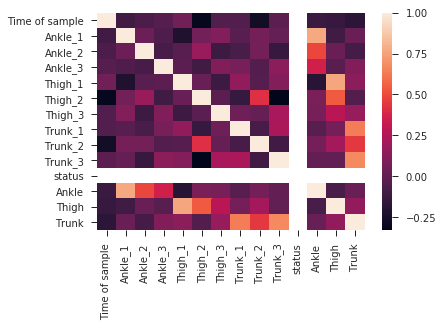

In [205]:
import seaborn as sns
corr = df_normal.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

By examining the above correlation matrix, we can approximate the readings of "Ankle_1", "Ankle_2" and "Ankle_3" into a combined "Ankle" and repeat the same for "Thigh" and "Trunk"

In [206]:
df_normal.head()

,Time of sample,Ankle_1,Ankle_2,Ankle_3,Thigh_1,Thigh_2,Thigh_3,Trunk_1,Trunk_2,Trunk_3,status,Ankle,Thigh,Trunk
15999,250000,-161,1029,99,-190,981,171,58,1028,116,1,967,962,1202
16000,250015,-131,1019,89,-136,972,151,38,1000,106,1,977,987,1144
16001,250031,-121,1019,99,-100,981,111,9,990,155,1,997,992,1154
16002,250046,-111,1029,69,-81,981,90,29,1000,126,1,987,990,1155
16003,250062,-101,1019,59,-81,981,90,0,990,155,1,977,990,1145


In [15]:
#

df_1_avged = np.array([sum(df_1["Ankle_1"].iloc[i:i+4]) for i in range(0,27256, 8)])
df_1_avged

array([-524, -433, -484, ..., -614, -694, -634])

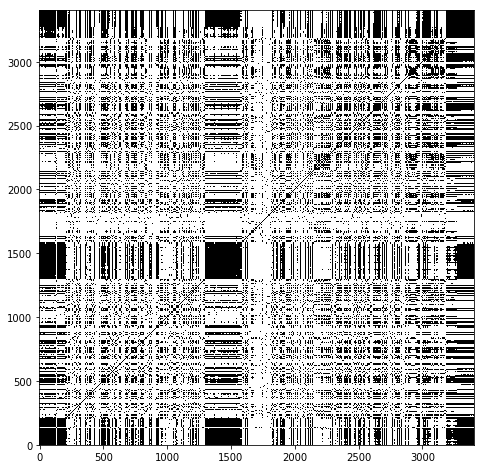

In [17]:

from pyts.image import RecurrencePlots
rp = RecurrencePlots(dimension=1,
                     epsilon='percentage_points',
                     percentage=30)

X_rp = rp.fit_transform(df_1_avged.reshape(1,-1))
# X_rp = rp.fit_transform(X)

# Show the results for the first time series
plt.figure(figsize=(8, 8))
plt.imshow(X_rp[0], cmap='binary', origin='lower')
plt.show()



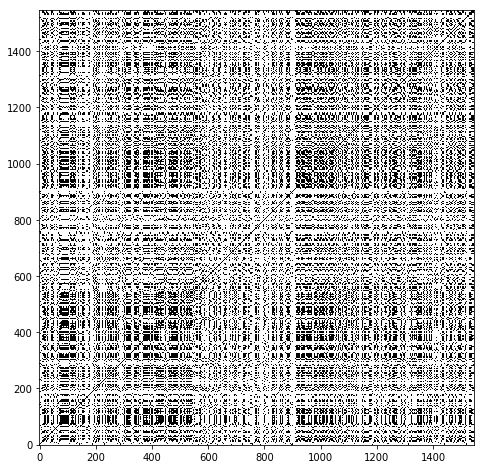

In [19]:
X_rp = rp.fit_transform(df_2["Ankle_1"].values.reshape(1,-1))
# X_rp = rp.fit_transform(X)

# Show the results for the first time series
plt.figure(figsize=(8, 8))
plt.imshow(X_rp[0], cmap='binary', origin='lower')
plt.show()
